In [ ]:
!pip install gym

In [ ]:
!pip install gym[atari,accept-rom-license]

In [ ]:
!pip install swig

In [ ]:
!pip install box2D-py

In [ ]:
!pip install gym[box2d]

In [6]:
import gym
import matplotlib.pyplot as plt


# Problem 1 : Deep Deterministic Policy Gradients

(a)

In [7]:
env = gym.make('MountainCarContinuous-v0')

state_space = env.observation_space
action_space = env.action_space

print(f'State space: {state_space}')
print(f'Action space: {action_space}')

State space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Action space: Box(-1.0, 1.0, (1,), float32)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [8]:
env = gym.make('LunarLanderContinuous-v2')

state_space = env.observation_space
action_space = env.action_space

print(f'State space: {state_space}')
print(f'Action space: {action_space}')

State space: Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
Action space: Box(-1.0, 1.0, (2,), float32)


In [9]:
num_ep = 100

def RandomAgent(env_name, num_ep):

  env = gym.make(env_name)

  rewards = []

  for i in range(num_ep):
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
      action = env.action_space.sample()
      next_state, reward, done, *_ = env.step(action)
      total_reward += reward
    rewards.append(total_reward)
  env.close()

  plt.plot(rewards)
  plt.xlabel('Episode')
  plt.ylabel('Total Reward')
  plt.title(f'Random Agent Performance on {env_name}')
  plt.show()

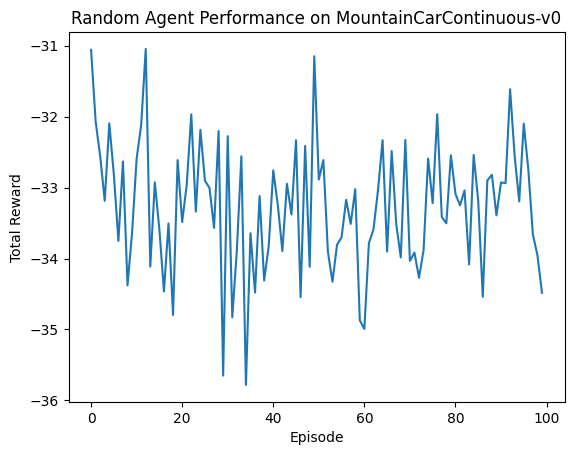

In [10]:
env_name1 = 'MountainCarContinuous-v0'
RandomAgent(env_name1, num_ep)

**Mountain Car Continuous-v0**

- The starting position of the car is a random value in [-0.6 , -0.4]. The starting velocity of the car is always 0.

- The state space is a ndarray with shape (2,) where the elements correspond to position of the car along the x-axis and velocity of the car.

- The action space is a ndarray with shape (1,) representing the directional force applied on the car from the range -1 to 1.

- A reward of $-0.1 \times (\text{action})^2$ is received at each time step to penalize for taking actions of large magnitude. and +100 for reaching the goal state.

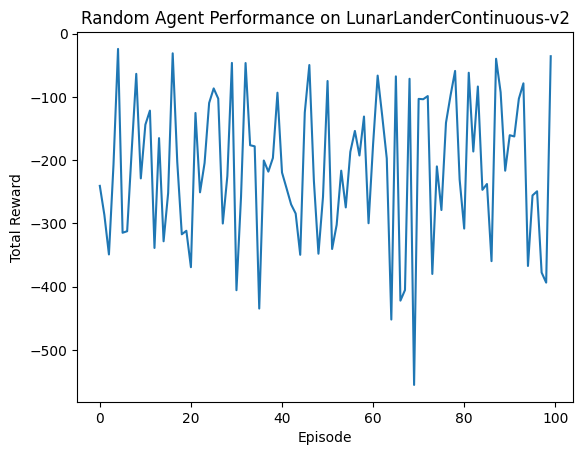

In [11]:
env_name2 = 'LunarLanderContinuous-v2'
RandomAgent(env_name2, num_ep)

**Lunar Lander Continuous-v2**

- The state space is 8-dimensional vector where the elements are position coordinates in x and y direction, its linear velocities in x and y direction, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.

- The action space is a ndarray with shape (2,) representing the directional forces applied on the lander in the range -1 to 1.

- A reward of -100 if the lander crashes, +100 if it comes to rest, +10 if any leg touches the ground, -0.3 for firing the main engine, -0.03 for firing the side engine , +200 if it solved.

Its clear from the above graphs that random agent does not help us reach the goal state in both the environments

(b)

In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import random
from collections import deque

In [13]:
class Critic(nn.Module):
    def __init__(self, state_size, action_size):
        super(Critic, self).__init__()
        self.L1 = nn.Linear(state_size + action_size, 128)
        self.L2 = nn.Linear(128, 128)
        self.L3 = nn.Linear(128, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.L1(x))
        x = F.relu(self.L2(x))
        x = self.L3(x)
        return x


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()
        self.L1 = nn.Linear(state_size, 128)
        self.L2 = nn.Linear(128, 128)
        self.L3 = nn.Linear(128, action_size)

    def forward(self, state):
        x = F.relu(self.L1(state))
        x = F.relu(self.L2(x))
        x = torch.tanh(self.L3(x))
        return x

In [15]:
class DDPGAgent:
  def __init__(self, state_size, action_size):

    self.actor = Actor(state_size, action_size)
    self.target_actor = Actor(state_size, action_size)
    self.critic = Critic(state_size, action_size)
    self.target_critic = Critic(state_size, action_size)

    self.target_actor.load_state_dict(self.actor.state_dict())
    self.target_critic.load_state_dict(self.critic.state_dict())

    self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-3)
    self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)

    self.memory = deque(maxlen=100000)

  def get_action(self, state):
    state = torch.FloatTensor(state).unsqueeze(0)
    with torch.no_grad():
      action = self.actor(state).squeeze(0)
    return action.numpy()

  def experience(self, state, action, reward, next_state, done):
    self.memory.append((state, action, np.array([reward]), next_state, done))

  def learn_model(self, batch_size, gamma=0.99, tau=0.01):
    if len(self.memory) < batch_size:
      return

    batch = random.sample(self.memory, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.FloatTensor(states)
    actions = torch.FloatTensor(actions)
    rewards = torch.FloatTensor(rewards)
    next_states = torch.FloatTensor(next_states)
    dones = torch.FloatTensor(dones).unsqueeze(1)

    with torch.no_grad():
      target_actions = self.target_actor(next_states)
      target_values = self.target_critic(next_states, target_actions)
      target_Q = rewards + (1 - dones) * gamma * target_values

    current_Q = self.critic(states, actions)

    critic_loss = F.mse_loss(current_Q, target_Q)

    self.critic_optimizer.zero_grad()
    critic_loss.backward()
    self.critic_optimizer.step()

    actor_loss = -self.critic(states, self.actor(states)).mean()

    self.actor_optimizer.zero_grad()
    actor_loss.backward()
    self.actor_optimizer.step()

    for target_param, param in zip(self.target_critic.parameters(), self.critic.parameters()):
      target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

    for target_param, param in zip(self.target_actor.parameters(), self.actor.parameters()):
      target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
def train(env_name, num_episodes):

  env = gym.make(env_name)
  state_size = env.observation_space.shape[0]
  action_size = env.action_space.shape[0]

  agent = DDPGAgent(state_size, action_size)

  rewards = []
  avg_rewards = []
  t=0
  for i in range(num_episodes):
      state = env.reset()
      noise.reset()
      total_reward = 0

      for j in range(steps):
          action = agent.get_action(state)
          action = noise.get_action(action, t)
          t += 1
          next_state, reward, done, _ = env.step(action)
          agent.experience(state, action, reward, next_state, done)
          agent.learn_model(batch_size)

          state = next_state
          total_reward += reward

          if done:
              break

      rewards.append(total_reward)
      avg_rewards.append(np.mean(rewards[-10:]))
  env.close()

  plt.plot(rewards, label='Episodic Reward')
  plt.plot(avg_rewards,label='Average Reward')
  plt.xlabel('Episode')
  plt.ylabel('Reward')
  plt.title(f'Learning Graph of {env_name}')
  plt.legend()
  plt.show()


In [17]:
num_episodes = 100
batch_size = 32
steps = 1000

In [18]:
class OU_noise():
    def __init__(self, action_space, mu=0, theta=0.1, max_sigma=0.3, min_sigma=0.2, decay_period=100000):
        self.mu = mu
        self.theta = theta
        self.sigma = max_sigma
        self.max_sigma = max_sigma
        self.min_sigma = min_sigma
        self.decay_period = decay_period
        self.action_size = action_space.shape[0]

        self.low = action_space.low
        self.high = action_space.high

        self.reset()

    def reset(self):
        self.state = np.ones(self.action_size)*self.mu

    def get_state(self):
        x = self.state
        dx = self.theta*(self.mu - x) + self.sigma*np.random.randn(self.action_size)
        self.state = x + dx
        return self.state

    def get_action(self, action, t=0):
      noise_state = self.get_state()
      self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma)*min(1.0, t/self.decay_period)
      return np.clip(action + noise_state, self.low, self.high)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
<ipython-input-15-4a9a15abb448>:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  states = torch.FloatTensor(states)


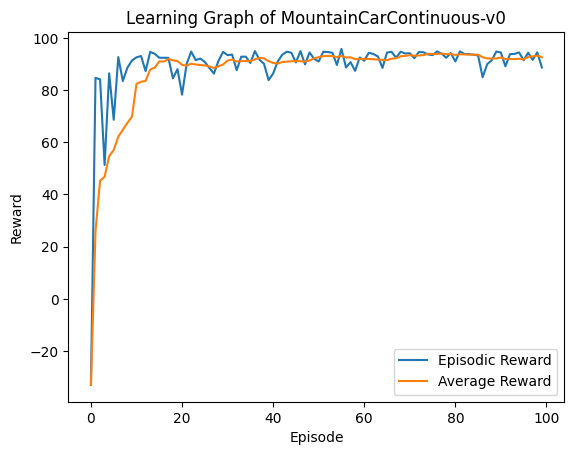

In [19]:
env = gym.make(env_name1)
noise = OU_noise(env.action_space)
train(env_name1, num_episodes)

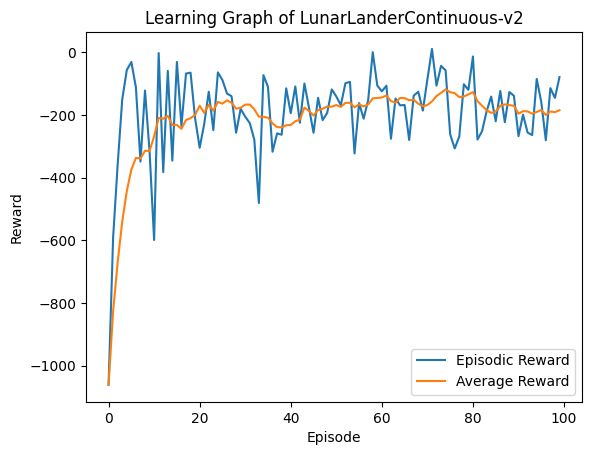

In [20]:
env = gym.make(env_name2)
noise = OU_noise(env.action_space)
train(env_name2, num_episodes)

(c)

In [21]:
class GaussNoise():
    def __init__(self, action_space, mu=0, max_sigma=0.3, min_sigma=0.2, decay_period=100000):
        self.mu = mu
        self.sigma = max_sigma
        self.max_sigma = max_sigma
        self.min_sigma = min_sigma
        self.decay_period = decay_period
        self.action_size = action_space.shape[0]

        self.low = action_space.low
        self.high = action_space.high

        self.reset()

    def reset(self):
      pass

    def get_action(self, action, t=0):
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma)*min(1.0, t/self.decay_period)
        noise = np.random.normal(self.mu, self.sigma, self.action_size)
        return np.clip(action + noise, self.low, self.high)


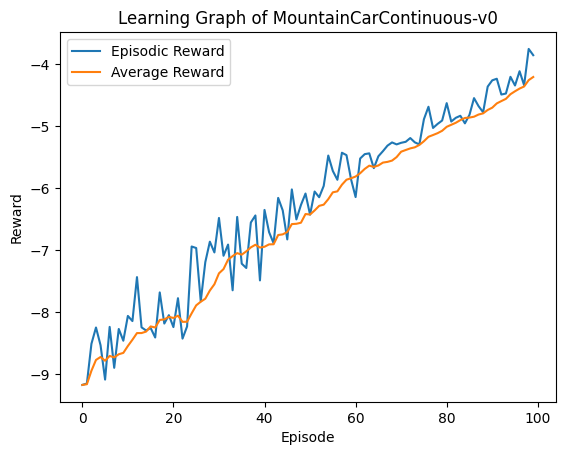

In [22]:
env = gym.make(env_name1)
noise = GaussNoise(env.action_space)
train(env_name1, num_episodes)

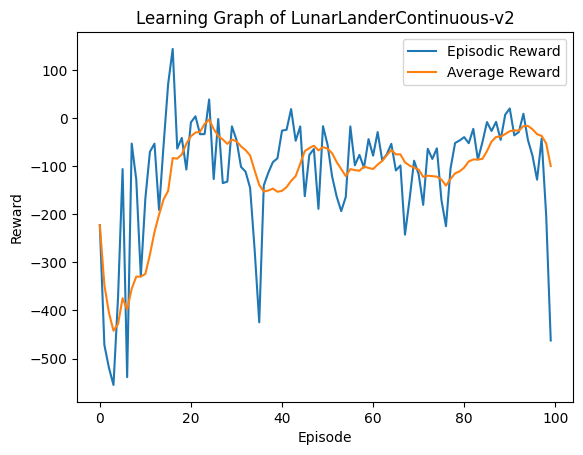

In [23]:
env = gym.make(env_name2)
noise = GaussNoise(env.action_space)
train(env_name2, num_episodes)

From the above plot we can say that on using gaussian noise for exploration takes more number of episodes to converge.

Reasons:

- Gaussian noise is uncorrelated over time steps, resulting in more unpredictable exploration. Each noise sample is independent, which can lead to abrupt changes in actions and exploration trajectories which is not the case with OU noise.

- The correlation in OU noise leads to smoother exploration paths unlike gaussian which has high variability in actions at each time step


# Problem 2 : Bandit Algorithms

(a)

In [ ]:
import numpy as np

class Bandit():
  def __init__(self, K, means):
    self.K = K
    self.means = means
    self.variance = 1.0

  def pull_arm(self, arm):
    mean_reward = self.means[arm]
    reward = np.random.normal(mean_reward, self.variance)
    return reward


(b)

In [ ]:
def greedy(env, M, N):

  q_values = np.zeros(env.K)
  action_counts = np.zeros(env.K)

  rewards = []
  regrets = []
  regret = 0

  for i in range(M):
    for j in range(env.K):
      reward = env.pull_arm(j)
      rewards.append(reward)
      action_counts[j] += 1
      q_values[i] += (reward - q_values[i])/action_counts[i]
      regret += np.max(env.means) - reward
      regrets.append(regret)

  for i in range(N-env.K):
    arm = np.argmax(q_values)
    action_counts[arm] += 1
    reward = env.pull_arm(arm)
    rewards.append(reward)
    q_values[arm] += (reward - q_values[arm])/action_counts[arm]
    regret += np.max(env.means) - reward
    regrets.append(regret)

  return rewards, action_counts, regrets


In [ ]:
def epsilon_greedy(env, M, N, epsilon):

  q_values = np.zeros(env.K)
  action_counts = np.zeros(env.K)

  rewards = []
  regrets = []
  regret = 0

  for i in range(M):
    for j in range(env.K):
      reward = env.pull_arm(j)
      rewards.append(reward)
      action_counts[j] += 1
      q_values[i] += (reward - q_values[i])/action_counts[i]
      regret += np.max(env.means) - reward
      regrets.append(regret)

  for i in range(N-env.K):
    if np.random.random() < epsilon:
      arm = np.random.randint(env.K)
    else:
      arm = np.argmax(q_values)
    action_counts[arm] += 1
    reward = env.pull_arm(arm)
    rewards.append(reward)
    q_values[arm] += (reward - q_values[arm])/action_counts[arm]
    regret += np.max(env.means) - reward
    regrets.append(regret)


  return rewards, action_counts, regrets

In [ ]:
def epsilon_greedy_decay(env, M, N, epsilon, decay_rate):

  q_values = np.zeros(env.K)
  action_counts = np.zeros(env.K)

  rewards = []
  regrets = []
  regret = 0

  for i in range(M):
    for j in range(env.K):
      reward = env.pull_arm(j)
      rewards.append(reward)
      action_counts[j] += 1
      q_values[i] += (reward - q_values[i])/action_counts[i]
      regret += np.max(env.means) - reward
      regrets.append(regret)

  for i in range(N-env.K):
    if np.random.random() < epsilon:
      arm = np.random.randint(env.K)
    else:
      arm = np.argmax(q_values)
    action_counts[arm] += 1
    reward = env.pull_arm(arm)
    rewards.append(reward)
    q_values[arm] += (reward - q_values[arm])/action_counts[arm]
    epsilon = epsilon * decay_rate
    regret += np.max(env.means) - reward
    regrets.append(regret)


  return rewards, action_counts, regrets

In [ ]:
def UCB(env, M, N):

  q_values = np.zeros(env.K)
  action_counts = np.zeros(env.K)

  rewards = []
  regrets = []
  regret = 0

  for i in range(M):
    for j in range(env.K):
      reward = env.pull_arm(j)
      rewards.append(reward)
      action_counts[j] += 1
      q_values[i] += (reward - q_values[i])/action_counts[i]
      regret += np.max(env.means) - reward
      regrets.append(regret)

  for i in range(N-env.K):
    exploration_factor = np.sqrt(2*np.log(i+1)/action_counts)
    arm = np.argmax(q_values + exploration_factor)
    action_counts[arm] += 1
    reward = env.pull_arm(arm)
    rewards.append(reward)
    q_values[arm] += (reward - q_values[arm])/action_counts[arm]
    regret += np.max(env.means) - reward
    regrets.append(regret)


  return rewards, action_counts, regrets

In [ ]:
K=10
N=1000
means = np.linspace(-5, 4, 10)
np.random.shuffle(means)
print(means)

[ 1. -5.  2.  0. -1. -4.  3. -3.  4. -2.]


In [ ]:
avg_rewards_greedy = np.zeros(N)
avg_rewards_E_greedy1 = np.zeros(N)
avg_rewards_E_greedy2 = np.zeros(N)
avg_rewards_E_decay = np.zeros(N)
avg_rewards_UCB = np.zeros(N)

avg_count_greedy = np.zeros(K)
avg_count_E_greedy1 = np.zeros(K)
avg_count_E_greedy2 = np.zeros(K)
avg_count_E_decay = np.zeros(K)
avg_count_UCB = np.zeros(K)

avg_regret_greedy = np.zeros(N)
avg_regret_E_greedy1 = np.zeros(N)
avg_regret_E_greedy2 = np.zeros(N)
avg_regret_E_decay = np.zeros(N)
avg_regret_UCB = np.zeros(N)


In [ ]:
for i in range(100):
    env = Bandit(K, means)

    r, c, rg = greedy(env, 1, N)
    avg_rewards_greedy += np.array(r) / 100
    avg_count_greedy += np.array(c) / 100
    avg_regret_greedy += np.array(rg) / 100

    r, c, rg = epsilon_greedy(env, 1, N, 0.01)
    avg_rewards_E_greedy1 += np.array(r) / 100
    avg_count_E_greedy1 += np.array(c) / 100
    avg_regret_E_greedy1 += np.array(rg) / 100

    r, c, rg = epsilon_greedy(env, 1, N, 0.1)
    avg_rewards_E_greedy2 += np.array(r) / 100
    avg_count_E_greedy2 += np.array(c) / 100
    avg_regret_E_greedy2 += np.array(rg) / 100

    r, c, rg = epsilon_greedy_decay(env, 1, N, 0.1, 0.99)
    avg_rewards_E_decay += np.array(r) / 100
    avg_count_E_decay += np.array(c) / 100
    avg_regret_E_decay += np.array(rg) / 100

    r, c, rg = UCB(env, 1, N)
    avg_rewards_UCB += np.array(r) / 100
    avg_count_UCB += np.array(c) / 100
    avg_regret_UCB += np.array(rg) / 100

(c)

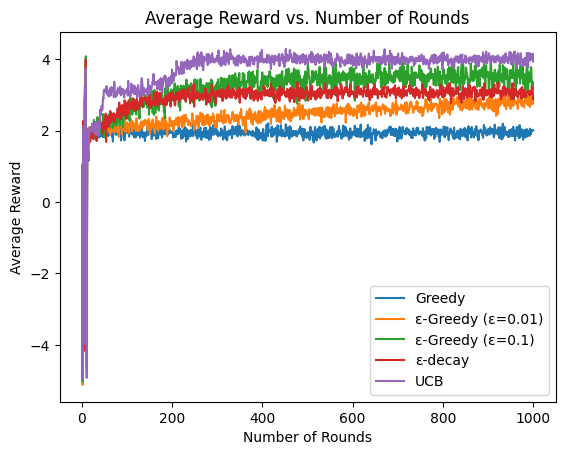

In [ ]:
rounds = np.arange(1, N + 1)
plt.plot(rounds, avg_rewards_greedy, label="Greedy")
plt.plot(rounds, avg_rewards_E_greedy1, label="ε-Greedy (ε=0.01)")
plt.plot(rounds, avg_rewards_E_greedy2, label="ε-Greedy (ε=0.1)")
plt.plot(rounds, avg_rewards_E_decay, label="ε-decay")
plt.plot(rounds, avg_rewards_UCB, label="UCB")

plt.xlabel("Number of Rounds")
plt.ylabel("Average Reward")
plt.title("Average Reward vs. Number of Rounds")
plt.legend()
plt.show()

(d)

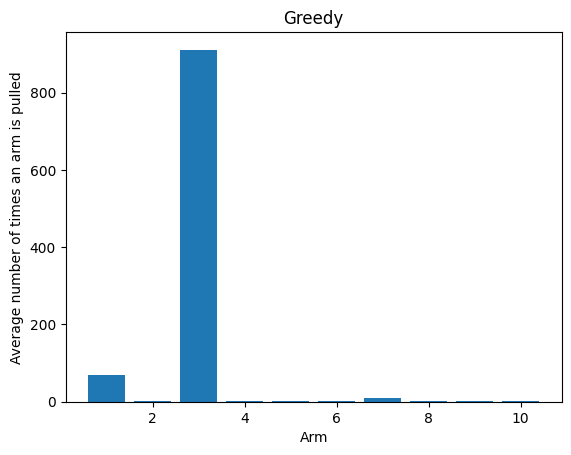

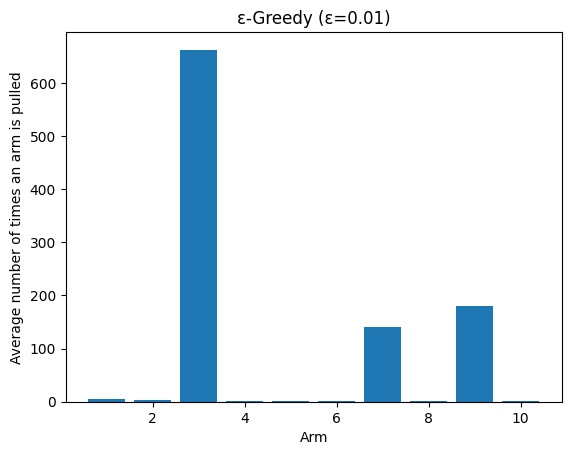

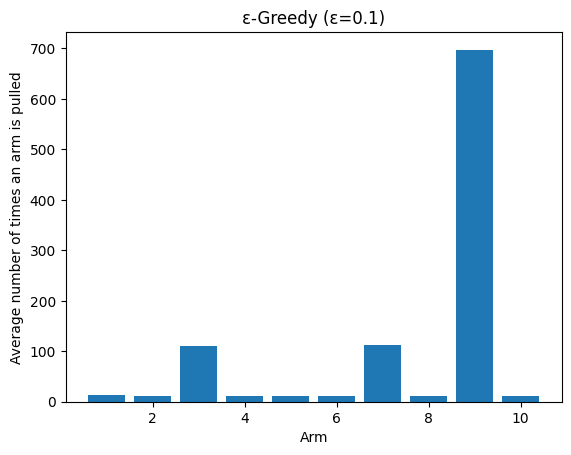

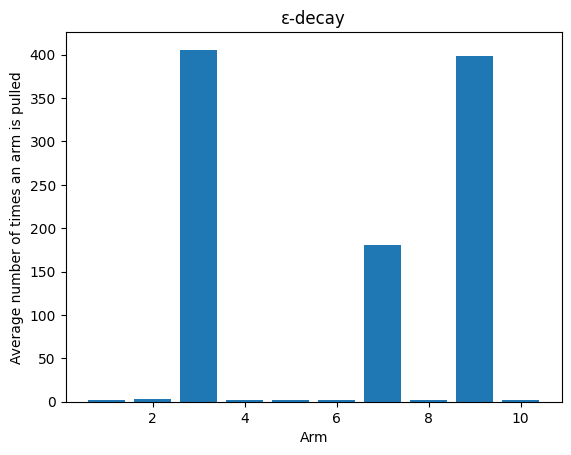

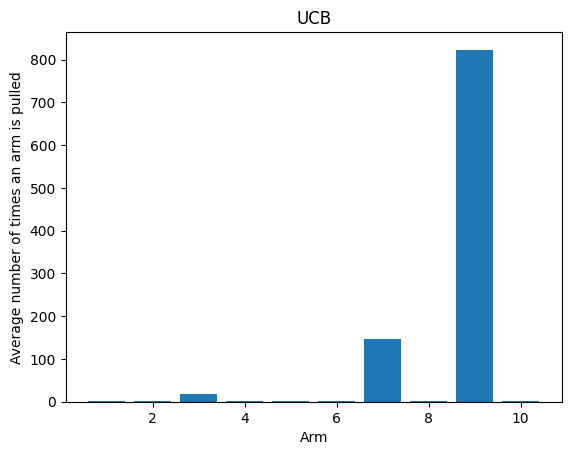

In [ ]:
arms = np.arange(1, K + 1)

plt.bar(arms, avg_count_greedy)
plt.title("Greedy")
plt.xlabel("Arm")
plt.ylabel("Average number of times an arm is pulled")
plt.show()


plt.bar(arms, avg_count_E_greedy1)
plt.title("ε-Greedy (ε=0.01)")
plt.xlabel("Arm")
plt.ylabel("Average number of times an arm is pulled")
plt.show()

plt.bar(arms, avg_count_E_greedy2)
plt.title("ε-Greedy (ε=0.1)")
plt.xlabel("Arm")
plt.ylabel("Average number of times an arm is pulled")
plt.show()

plt.bar(arms, avg_count_E_decay)
plt.title("ε-decay")
plt.xlabel("Arm")
plt.ylabel("Average number of times an arm is pulled")
plt.show()

plt.bar(arms, avg_count_UCB)
plt.title("UCB")
plt.xlabel("Arm")
plt.ylabel("Average number of times an arm is pulled")
plt.show()

(e)

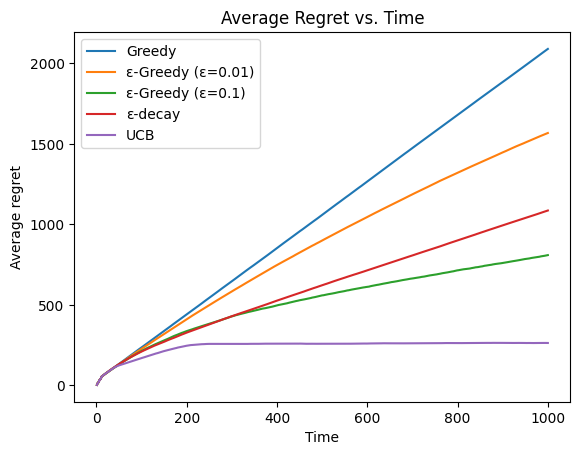

In [ ]:
rounds = np.arange(1, N + 1)
plt.plot(rounds, avg_regret_greedy, label="Greedy")
plt.plot(rounds, avg_regret_E_greedy1, label="ε-Greedy (ε=0.01)")
plt.plot(rounds, avg_regret_E_greedy2, label="ε-Greedy (ε=0.1)")
plt.plot(rounds, avg_regret_E_decay, label="ε-decay")
plt.plot(rounds, avg_regret_UCB, label="UCB")

plt.xlabel("Time")
plt.ylabel("Average regret")
plt.legend()
plt.title("Average Regret vs. Time")
plt.show()

(f)

From the above plots we can say that UCB algorithm has the maximum rewards and least regret making it the better algorithm than the others. It achieves this by balancing exploration and exploitation. UCB algorithm explores uncertain options, preventing getting stuck with suboptimal choices, while also exploiting more certain options.

(g)

In [ ]:
K=10
N=1000
means = np.array([-5, -4, -3, -2, -1, 0, 1, 2, 3.8, 4])
np.random.shuffle(means)
print(means)

[ 1.  -1.   0.   2.  -3.  -4.  -5.  -2.   4.   3.8]


In [ ]:
avg_rewards_greedy = np.zeros(N)
avg_rewards_E_greedy1 = np.zeros(N)
avg_rewards_E_greedy2 = np.zeros(N)
avg_rewards_E_decay = np.zeros(N)
avg_rewards_UCB = np.zeros(N)

avg_count_greedy = np.zeros(K)
avg_count_E_greedy1 = np.zeros(K)
avg_count_E_greedy2 = np.zeros(K)
avg_count_E_decay = np.zeros(K)
avg_count_UCB = np.zeros(K)

avg_regret_greedy = np.zeros(N)
avg_regret_E_greedy1 = np.zeros(N)
avg_regret_E_greedy2 = np.zeros(N)
avg_regret_E_decay = np.zeros(N)
avg_regret_UCB = np.zeros(N)


In [ ]:
for i in range(100):
    env = Bandit(K, means)

    r, c, rg = greedy(env, 1, N)
    avg_rewards_greedy += np.array(r) / 100
    avg_count_greedy += np.array(c) / 100
    avg_regret_greedy += np.array(rg) / 100

    r, c, rg = epsilon_greedy(env, 1, N, 0.01)
    avg_rewards_E_greedy1 += np.array(r) / 100
    avg_count_E_greedy1 += np.array(c) / 100
    avg_regret_E_greedy1 += np.array(rg) / 100

    r, c, rg = epsilon_greedy(env, 1, N, 0.1)
    avg_rewards_E_greedy2 += np.array(r) / 100
    avg_count_E_greedy2 += np.array(c) / 100
    avg_regret_E_greedy2 += np.array(rg) / 100

    r, c, rg = epsilon_greedy_decay(env, 1, N, 0.1, 0.99)
    avg_rewards_E_decay += np.array(r) / 100
    avg_count_E_decay += np.array(c) / 100
    avg_regret_E_decay += np.array(rg) / 100

    r, c, rg = UCB(env, 1, N)
    avg_rewards_UCB += np.array(r) / 100
    avg_count_UCB += np.array(c) / 100
    avg_regret_UCB += np.array(rg) / 100

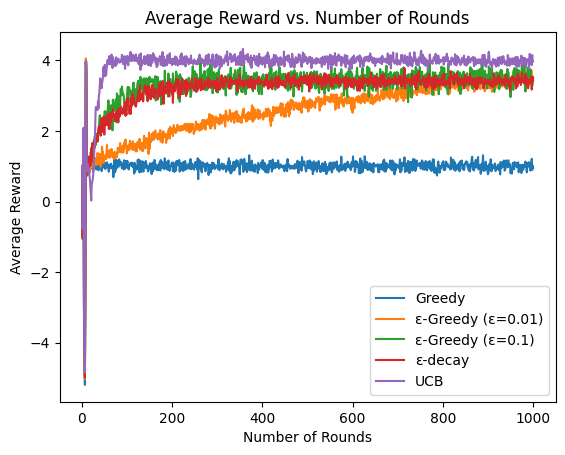

In [ ]:
rounds = np.arange(1, N + 1)
plt.plot(rounds, avg_rewards_greedy, label="Greedy")
plt.plot(rounds, avg_rewards_E_greedy1, label="ε-Greedy (ε=0.01)")
plt.plot(rounds, avg_rewards_E_greedy2, label="ε-Greedy (ε=0.1)")
plt.plot(rounds, avg_rewards_E_decay, label="ε-decay")
plt.plot(rounds, avg_rewards_UCB, label="UCB")

plt.xlabel("Number of Rounds")
plt.ylabel("Average Reward")
plt.title("Average Reward vs. Number of Rounds")
plt.legend()
plt.show()

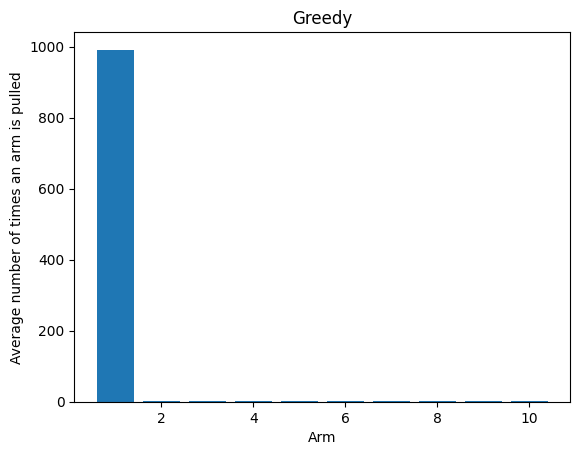

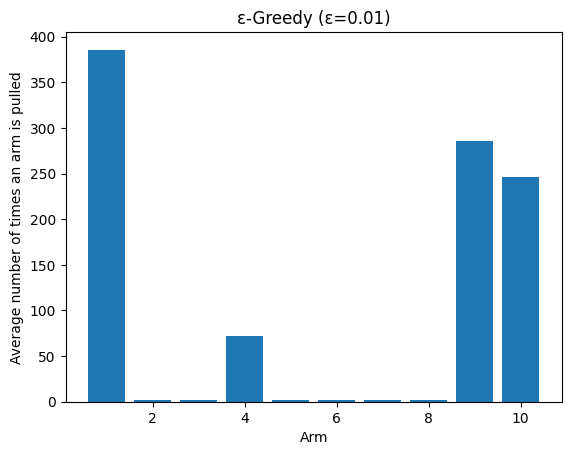

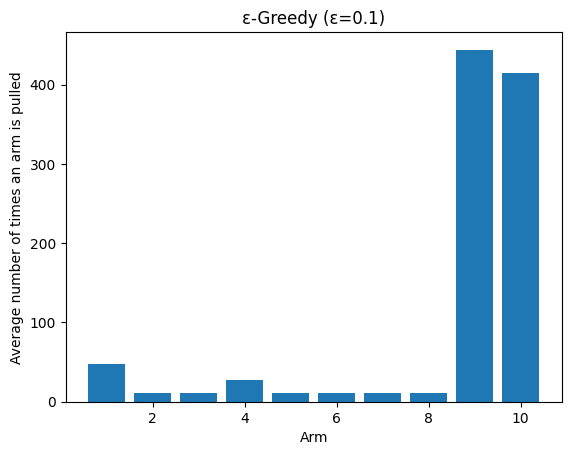

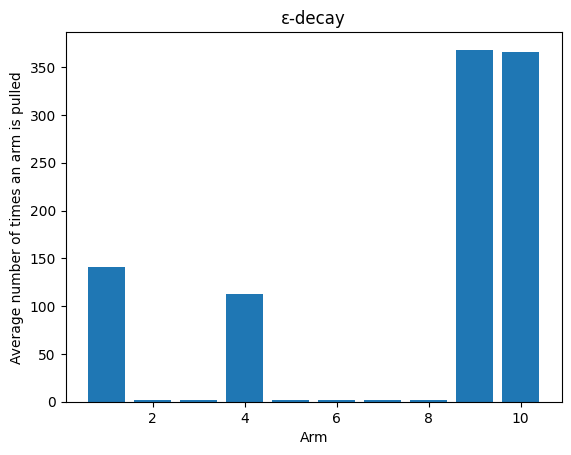

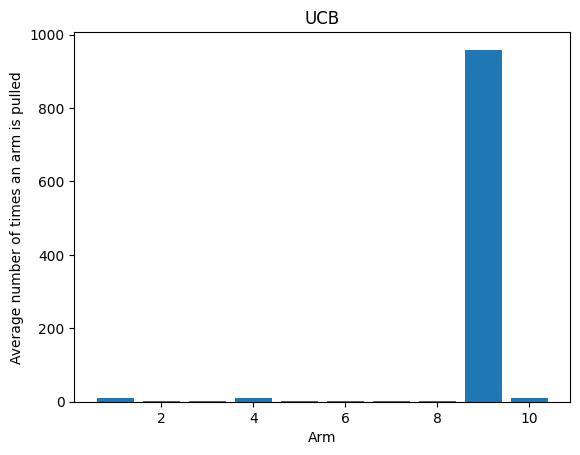

In [ ]:
arms = np.arange(1, K + 1)

plt.bar(arms, avg_count_greedy)
plt.title("Greedy")
plt.xlabel("Arm")
plt.ylabel("Average number of times an arm is pulled")
plt.show()


plt.bar(arms, avg_count_E_greedy1)
plt.title("ε-Greedy (ε=0.01)")
plt.xlabel("Arm")
plt.ylabel("Average number of times an arm is pulled")
plt.show()

plt.bar(arms, avg_count_E_greedy2)
plt.title("ε-Greedy (ε=0.1)")
plt.xlabel("Arm")
plt.ylabel("Average number of times an arm is pulled")
plt.show()

plt.bar(arms, avg_count_E_decay)
plt.title("ε-decay")
plt.xlabel("Arm")
plt.ylabel("Average number of times an arm is pulled")
plt.show()

plt.bar(arms, avg_count_UCB)
plt.title("UCB")
plt.xlabel("Arm")
plt.ylabel("Average number of times an arm is pulled")
plt.show()

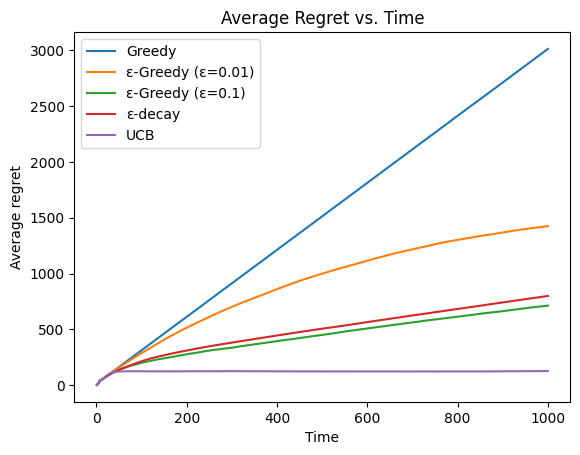

In [ ]:
rounds = np.arange(1, N + 1)
plt.plot(rounds, avg_regret_greedy, label="Greedy")
plt.plot(rounds, avg_regret_E_greedy1, label="ε-Greedy (ε=0.01)")
plt.plot(rounds, avg_regret_E_greedy2, label="ε-Greedy (ε=0.1)")
plt.plot(rounds, avg_regret_E_decay, label="ε-decay")
plt.plot(rounds, avg_regret_UCB, label="UCB")

plt.xlabel("Time")
plt.ylabel("Average regret")
plt.legend()
plt.title("Average Regret vs. Time")
plt.show()

When the mean rewards of the second best arm and the best arm are close, the algorithms that explore more (like ε-greedy with higher ε values or UCB) tend to perform better which can be seen from the above regret plot.

From the average number of pulls plot we can see that the number of pulls for second best are almost the same except for UCB which has comparatively higher average number of pulls than the second best and greedy doesn't perform well

Except for greedy, covergent value of average reward value of other algorithms are nearer to eachother